# QDAC-II 1D & 2D scan

In [1]:
from time import sleep
import numpy as np
from IPython.display import Image, display
from qcodes_contrib_drivers.drivers.QDevil import QDAC2
qdac_addr = '192.168.8.17'
qdac = QDAC2.QDac2('QDAC', visalib='@py', address=f'TCPIP::{qdac_addr}::5025::SOCKET')
import qcodes.instrument_drivers.rigol.DS1074Z as DS1000Z
rigol_addr = '192.168.8.199'
scope = DS1000Z.DS1074Z('rigol', visalib='@py', address=f'TCPIP::{rigol_addr}::INSTR')

Connected to: QDevil QDAC-II (serial:3, firmware:10-1.4) in 0.21s
Connected to: RIGOL TECHNOLOGIES DS1104Z (serial:DS1ZA171812151, firmware:00.04.03) in 0.05s


In [2]:
scope.write('*rst')
qdac.reset()

In [3]:
def capture():
    scope.write('stop')
    scope.write(":disp:data?")
    bmpdata = scope.visa_handle.read_raw()[2+9:]
    image = Image(data=bmpdata)
    display(image)

In [4]:
# Connect scope ch 2 & 3 to qdac ch 2 & 3
scope.write('chan1:disp off')
scope.write('chan2:disp on')
scope.write('chan2:bwl on')
scope.write('chan2:prob 1')
scope.write('chan2:scal 0.2')
scope.write('chan2:offs 0.0')
scope.write('chan3:disp on')
scope.write('chan3:bwl on')
scope.write('chan3:prob 1')
scope.write('chan3:scal 0.2')
scope.write('chan3:offs 0.0')
# Connect scope ch 4 to qdac output trigger 4
scope.write('chan4:disp on')
scope.write('chan4:bwl on')
scope.write('chan4:prob 1')
scope.write('chan4:scal 1')
scope.write('chan4:offs -2')
scope.write('trig:edge:sour chan2')
scope.write('trig:edge:level 0')
scope.write('tim:scal 20e-6')
scope.write('tim:offs 80e-6')

In [5]:
arrangement = qdac.arrange(
        # QDAC channels 2 & 3 connected to sample
        gates={'plunger2': 2, 'plunger3': 3},
        # DMM external trigger connected to QDAC Output Trigger 4
        output_triggers={'dmm': 4})

In [6]:
# Perform 1D sweep
sweep = arrangement.virtual_sweep(
        gate='plunger2',
        voltages=np.linspace(-0.5, 0.5, 25),
        step_time_s=10e-6,
        step_trigger='dmm')

In [7]:
scope.write('sing')
sleep(3)
sweep.start()

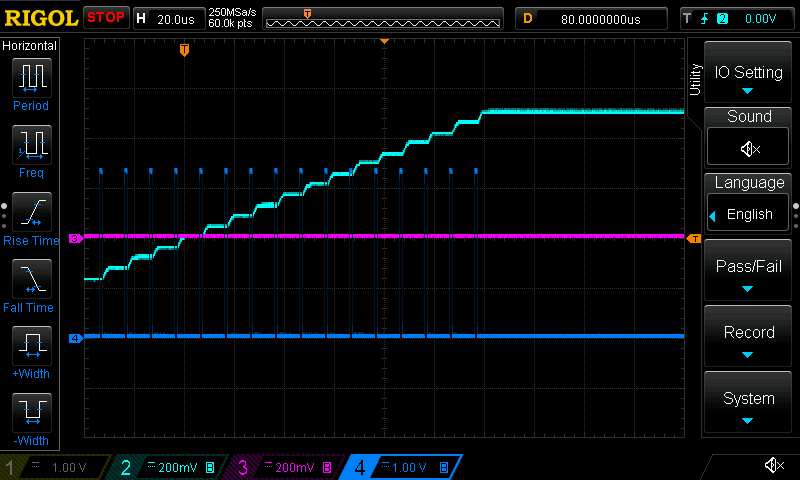

In [14]:
capture()

In [8]:
# Perform 2D sweep
sweep = arrangement.virtual_sweep2d(
        inner_gate='plunger2',
        inner_voltages=np.linspace(-0.2, 0.6, 5),
        outer_gate='plunger3',
        outer_voltages=np.linspace(-0.7, 0.15, 4),
        inner_step_time_s=10e-6,
        inner_step_trigger='dmm')

In [9]:
scope.write('sing')
sleep(3)
sweep.start()

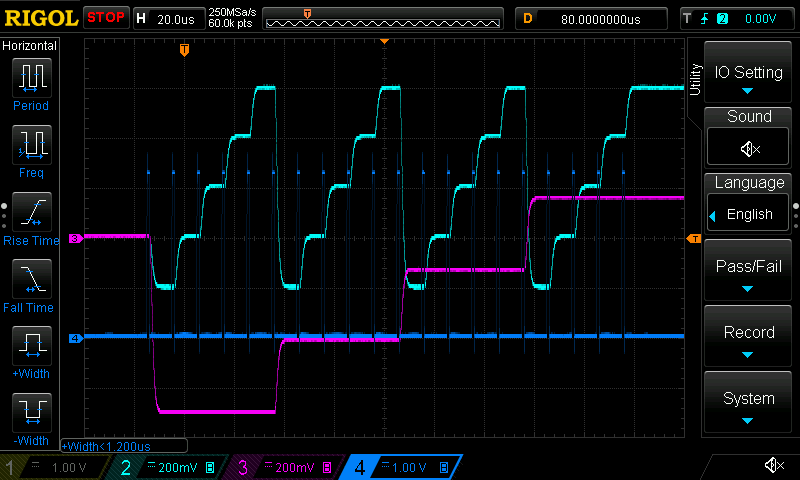

In [8]:
capture()

In [10]:
# Perform a detuning by sweeping two times between -0.2 to 0.2 and 0.0 to -0.3
sweep = arrangement.virtual_detune(
        gates=('plunger2', 'plunger3'), 
        start_V=(-0.2, 0.0), 
        end_V=(0.2, -0.3), 
        steps=5,
        step_trigger='dmm',
        repetitions=2)

In [11]:
scope.write('sing')
sleep(3)
sweep.start()

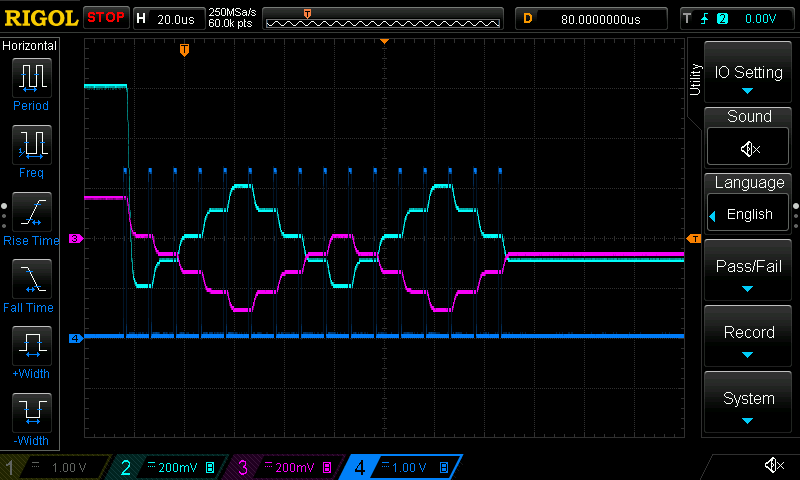

In [12]:
capture()